In [1]:
import psycopg2
from twelvedata import TDClient

from dotenv import load_dotenv
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

import tensorflow as tf
from tensorflow import keras

2023-07-17 13:53:19.646917: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 13:53:20.833719: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-17 13:53:20.850947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 13:53:27.882550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#get today's date
today = time.strftime("%Y-%m-%d")
print(today)

2023-07-17


In [3]:
tdapikey = os.environ['TDAPIKEY']
ticker = 'AAPL'

td = TDClient(apikey=tdapikey)
ts = td.time_series(symbol=ticker, interval="1h", start_date="2020-01-01", end_date=today, outputsize=5000)
ts.as_pandas()

,open,high,low,close,volume
datetime,,,,,
2023-07-14 15:30:00,190.27499,190.74001,190.1600,190.73000,5002552
2023-07-14 14:30:00,190.20000,190.42000,189.7800,190.27499,4052940
2023-07-14 13:30:00,190.01010,190.56500,189.9501,190.19000,3213789
2023-07-14 12:30:00,189.95000,190.14999,189.6300,190.01500,3352688
2023-07-14 11:30:00,190.36501,190.62000,189.8900,189.95000,3952148
...,...,...,...,...,...
2020-09-09 13:30:00,118.33000,118.38000,117.1100,117.54000,4089566
2020-09-09 12:30:00,117.98000,119.13000,117.8200,118.28000,9757993
2020-09-09 11:30:00,117.92000,118.31000,117.3300,117.95000,5319076


<Axes: xlabel='datetime'>

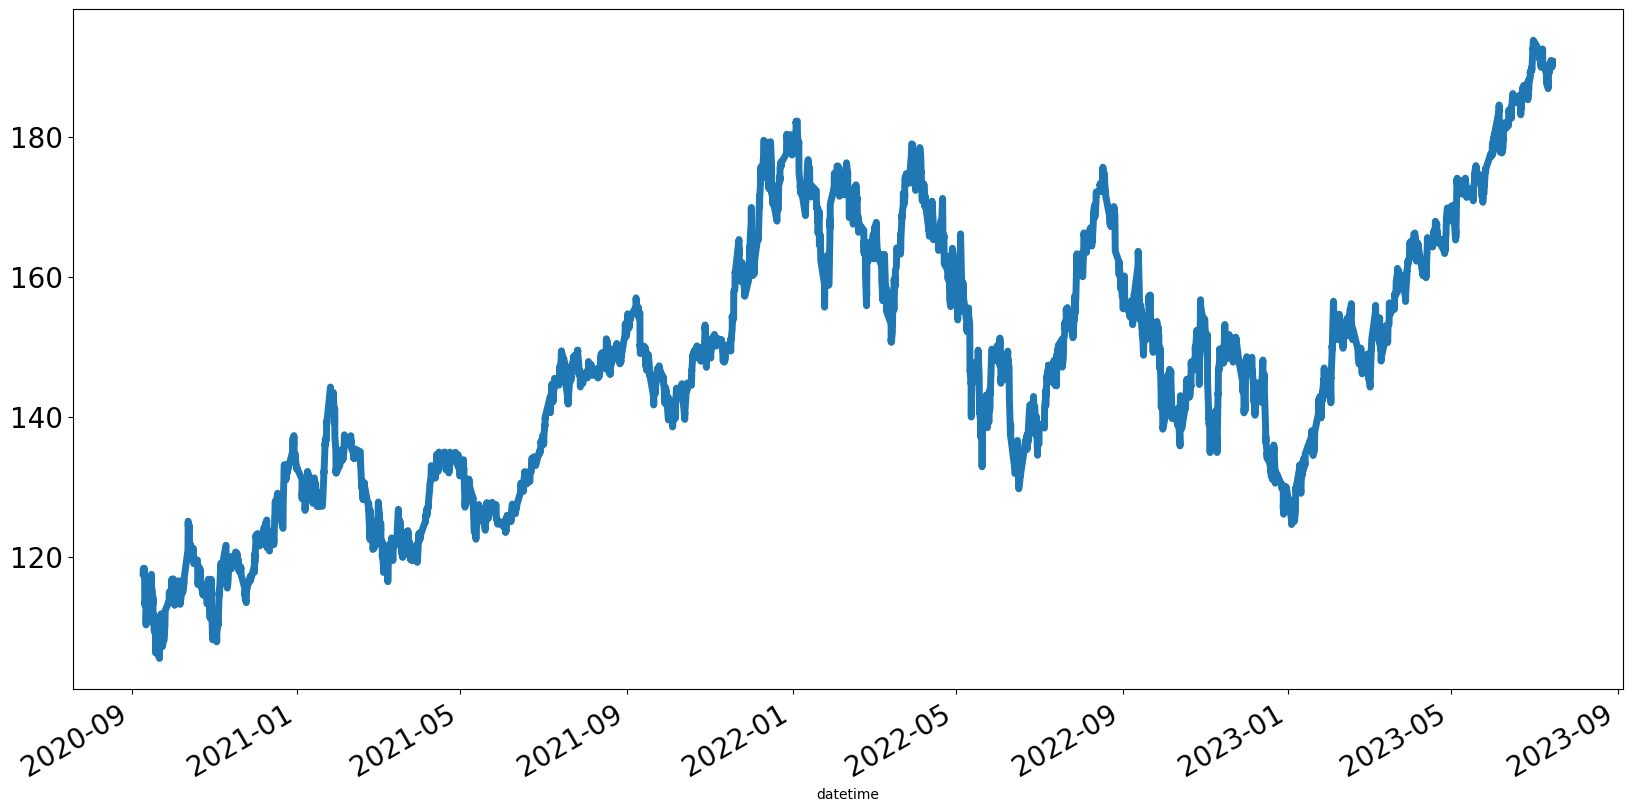

In [4]:
ts.as_pandas()['close'].plot(figsize=(20,10), linewidth=5, fontsize=20)

In [5]:
# create dataset X and y, rolling window of 7 days
df = ts.as_pandas()['close']
# reverse
df = df.iloc[::-1]

time_steps_past = 6*24 # 6 days * 24 hours
time_steps_future = 1*24
X = []
y = []
for i in range(time_steps_past, len(df)-time_steps_future):
    X.append(df[i-time_steps_past:i])
    y.append(df[i+time_steps_future])

X, y = np.array(X), np.array(y)

In [6]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [109]:
# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train.reshape(-1,1))
y_test = scaler.transform(y_test.reshape(-1,1))

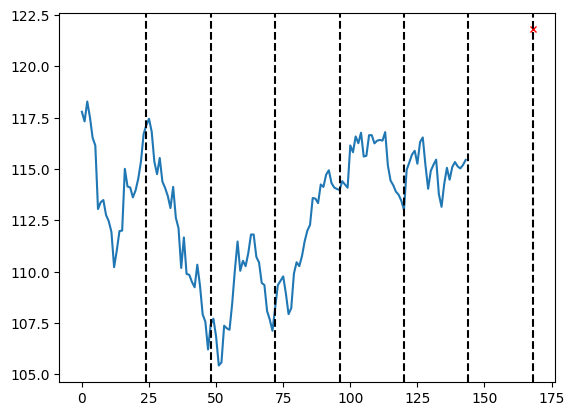

In [8]:
# plot one sample - past 6 days (X_train[0]) and the point 24 hours from now (y_train[0])
plt.plot(X_train[5])
plt.plot([time_steps_past+time_steps_future], [y_train[5]], 'x', color='red', markersize=4)
# vertical line every 24 hours
for i in range(1,8):
    plt.axvline(x=i*24, color='black', linestyle='--')
plt.show()

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3865, 144), (967, 144), (3865,), (967,))

### XGBoost

In [10]:
# fit model no training data
model = XGBRegressor()
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)

# evaluate predictions
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.10f" % mse)

MSE: 74.9590782454


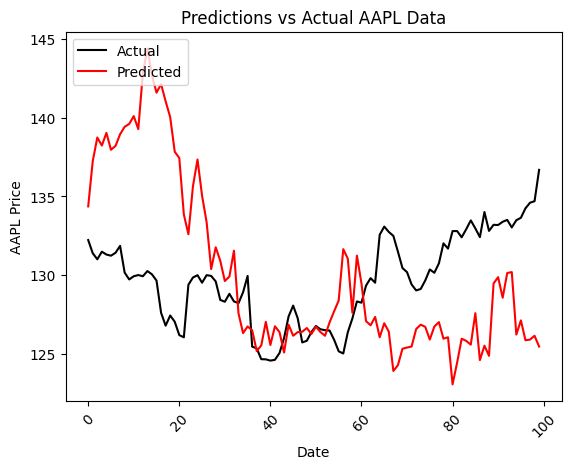

In [11]:
# plot predictions vs actual
plt.plot(y_test[:100], color = "black")
plt.plot(y_pred[:100], color = "red")
plt.ylabel(ticker+' Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions vs Actual "+ticker+" Data")
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.show()

In [117]:
# convert predictions back to original scale
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

In [118]:
# calculate MSE on original scale
mse = mean_squared_error(y_test_inv, y_pred_inv)
print("MSE: %.10f" % mse)

MSE: 107.8765739817


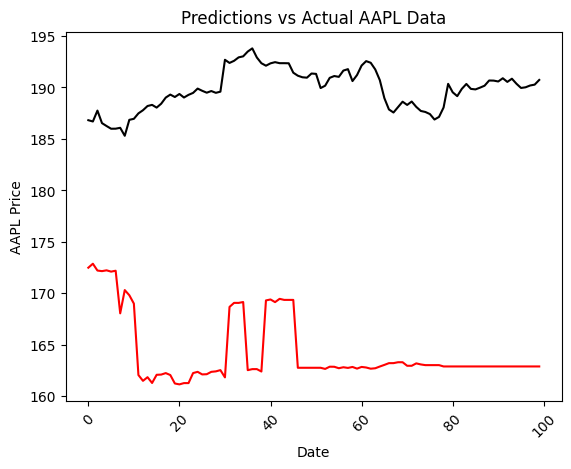

In [119]:
# plot predictions vs actual
plt.plot(y_test_inv[-100:], color = "black")
plt.plot(y_pred_inv[-100:], color = "red")
plt.ylabel(ticker+' Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions vs Actual "+ticker+" Data")
plt.show()

In [12]:
# save model
model.save_model("../models/xgb_model.json")

### Autoregressive NN

In [7]:
# scale the data
scalerx = StandardScaler()
X_train1 = scalerx.fit_transform(X_train)
X_test1 = scalerx.transform(X_test)

scalery = StandardScaler()
y_train1 = scalery.fit_transform(y_train.reshape(-1,1))
y_test1 = scalery.transform(y_test.reshape(-1,1))

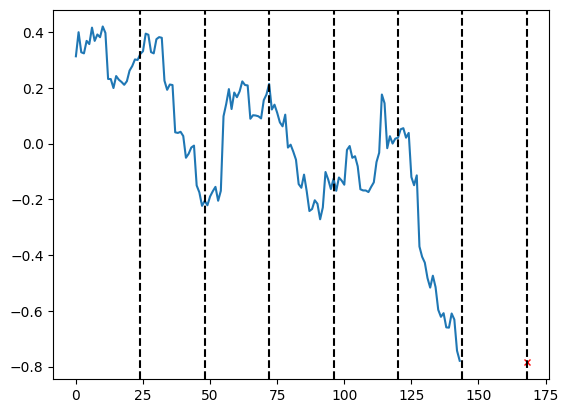

In [9]:
# plot one sample - past 6 days (X_train[0]) and the point 24 hours from now (y_train[0])
plt.plot(X_train1[-1])
plt.plot([time_steps_past+time_steps_future], [y_train1[-1]], 'x', color='red', markersize=4)
# vertical line every 24 hours
for i in range(1,8):
    plt.axvline(x=i*24, color='black', linestyle='--')
plt.show()

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.Dense(1)])

optimizer = keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.0)

model.compile(loss="mse", optimizer=optimizer)

history = model.fit(X_train1, y_train1, epochs=10, validation_split=0.1)

Epoch 1/10
109/109 [==============================] - 6s 36ms/step - loss: 0.1556 - val_loss: 0.1688
Epoch 2/10
109/109 [==============================] - 2s 19ms/step - loss: 0.1099 - val_loss: 0.1759
Epoch 3/10
109/109 [==============================] - 2s 17ms/step - loss: 0.1047 - val_loss: 0.1652
Epoch 4/10
109/109 [==============================] - 2s 21ms/step - loss: 0.1020 - val_loss: 0.1682
Epoch 5/10
109/109 [==============================] - 2s 21ms/step - loss: 0.1012 - val_loss: 0.1599
Epoch 6/10
109/109 [==============================] - 2s 18ms/step - loss: 0.1012 - val_loss: 0.1625
Epoch 7/10
109/109 [==============================] - 3s 30ms/step - loss: 0.0988 - val_loss: 0.1582
Epoch 8/10
109/109 [==============================] - 3s 29ms/step - loss: 0.0976 - val_loss: 0.1554
Epoch 9/10
109/109 [==============================] - 2s 23ms/step - loss: 0.0980 - val_loss: 0.1535
Epoch 10/10
109/109 [==============================] - 2s 23ms/step - loss: 0.0973 - val_lo

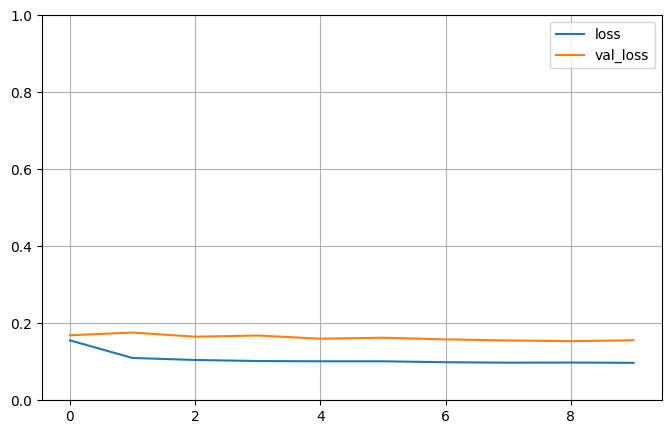

In [11]:
# plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [12]:
# make predictions
y_pred = model.predict(X_test1)

# evaluate predictions
mse = mean_squared_error(y_test1, y_pred)
print("MSE: %.10f" % mse)

31/31 [==============================] - 1s 12ms/step
MSE: 0.1021040165


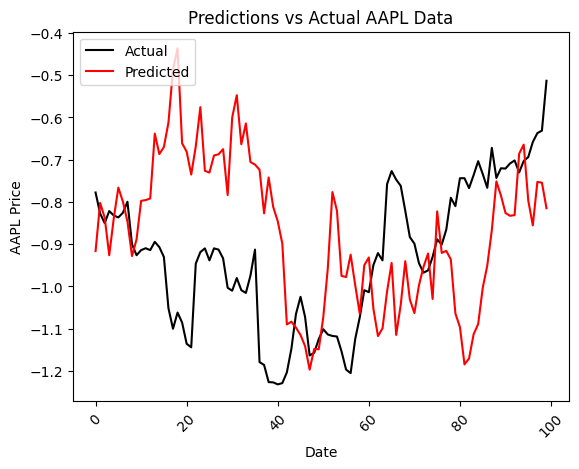

In [13]:
# plot predictions vs actual
plt.plot(y_test1[:100], color = "black")
plt.plot(y_pred[:100], color = "red")
plt.ylabel(ticker+' Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions vs Actual "+ticker+" Data")
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.show()

In [14]:
# convert predictions back to original scale
y_pred_inv = scalery.inverse_transform(y_pred.reshape(-1,1))
y_test_inv = scalery.inverse_transform(y_test1.reshape(-1,1))

In [15]:
# calculate MSE on original scale
mse = mean_squared_error(y_test_inv, y_pred_inv)
print("MSE: %.10f" % mse)

MSE: 29.0592444565


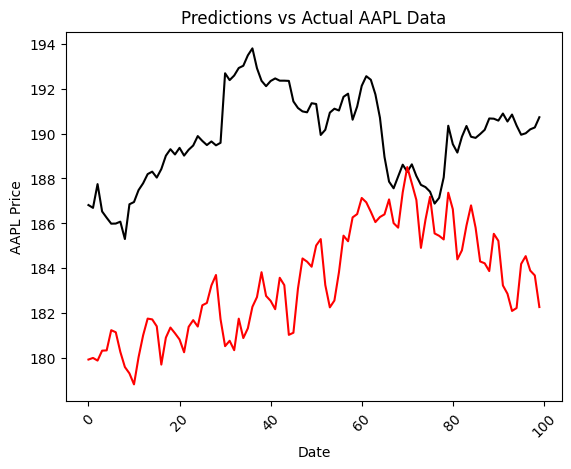

In [16]:
# plot predictions vs actual
plt.plot(y_test_inv[-100:], color = "black")
plt.plot(y_pred_inv[-100:], color = "red")
plt.ylabel(ticker+' Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions vs Actual "+ticker+" Data")
plt.show()

In [17]:
# save model
model.save("../models/nn_model.h5")

/home/drew99/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# save scaler
import joblib
joblib.dump(scalerx, "../models/scalerx.save")
joblib.dump(scalery, "../models/scalery.save")

['../models/scalery.save']